In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import scipy.stats as stats 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

I started by importing all files into pandas as dataframes from excel spreadsheets

In [2]:
df1 = pd.read_excel('IPPS_allDRG_FY2014.xlsx')
df2 = pd.read_excel('IPPS_allDRG_FY2015.xlsx')
df3 = pd.read_excel('IPPS_allDRG_FY2016.xlsx')
df4 = pd.read_excel('IPPS_allDRG_FY2017.xlsx')

I then added columns to each dataframe for their individual fiscal years

In [3]:
df1['Fiscal_Year'] = 2014
df2['Fiscal_Year'] = 2015
df3['Fiscal_Year'] = 2016
df4['Fiscal_Year'] = 2017

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202656 entries, 0 to 202655
Data columns (total 13 columns):
DRG Definition                                202656 non-null object
Provider Id                                   202656 non-null int64
Provider Name                                 202656 non-null object
Provider Street Address                       202656 non-null object
Provider City                                 202656 non-null object
Provider State                                202656 non-null object
Provider Zip Code                             202656 non-null int64
Hospital Referral Region (HRR) Description    202656 non-null object
Total Discharges                              202656 non-null int64
Average Covered Charges                       202656 non-null float64
Average Total Payments                        202656 non-null float64
Average Medicare Payments                     202656 non-null float64
Fiscal_Year                                   202656 non-null

I dropped the columns from each df for street address, city, HRR description, and total discharges, as I plan to look at a higher level overview of the data

In [5]:
df1 = df1.drop(['Provider Street Address', 'Provider City', 'Hospital Referral Region (HRR) Description', 'Total Discharges'], axis=1)
df2 = df2.drop(['Provider Street Address', 'Provider City', 'Hospital Referral Region (HRR) Description', 'Total Discharges'], axis=1)
df3 = df3.drop(['Provider Street Address', 'Provider City', 'Hospital Referral Region (HRR) Description', 'Total Discharges'], axis=1)
df4 = df4.drop(['Provider Street Address', 'Provider City', 'Hospital Referral Region (HRR) Description', 'Total Discharges'], axis=1)
df1.head()

,DRG Definition,Provider Id,Provider Name,Provider State,Provider Zip Code,Average Covered Charges,Average Total Payments,Average Medicare Payments,Fiscal_Year
0,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,10033,UNIVERSITY OF ALABAMA HOSPITAL,AL,35233,1172866.385,251876.3077,244457.9231,2014
1,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,30103,MAYO CLINIC HOSPITAL,AZ,85054,437531.300,240422.8000,133509.5500,2014
2,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50108,SUTTER GENERAL HOSPITAL,CA,95816,815674.120,233197.4800,221681.8000,2014
3,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50262,RONALD REAGAN U C L A MEDICAL CENTER,CA,90095,1499043.571,415968.7857,366608.9286,2014
4,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50441,STANFORD HOSPITAL,CA,94305,2238699.130,420865.4783,403453.6522,2014


I then merged the 4 dataframes together into one data frame

In [6]:
merge1 = df1.merge(df2, how='outer')
merge2 = df3.merge(df4, how='outer')
full_df = merge1.merge(merge2, how='outer')

I also split the column 'DRG Definition' into two columns: one with the code number and one with the description. 

In [7]:
code = full_df['DRG Definition'].str.split(" ", n=1, expand=True)
full_df['DRG_Code'] = code[0]
full_df['DRG_Definition'] = code[1]

Then I converted the DRG_Code column to integer values for easier manipulation later. I had planned to drop the 'DRG Definition' column, but found out later that it became useful. 

In [8]:
full_df['DRG_Code'] = full_df['DRG_Code'].apply(pd.to_numeric)

In [9]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798140 entries, 0 to 798139
Data columns (total 11 columns):
DRG Definition               798140 non-null object
Provider Id                  798140 non-null int64
Provider Name                798140 non-null object
Provider State               798140 non-null object
Provider Zip Code            798140 non-null int64
Average Covered Charges      798140 non-null float64
Average Total Payments       798140 non-null float64
Average Medicare Payments    798140 non-null float64
Fiscal_Year                  798140 non-null int64
DRG_Code                     798140 non-null int64
DRG_Definition               798140 non-null object
dtypes: float64(3), int64(4), object(4)
memory usage: 73.1+ MB


### Exploratory data analysis and statistics

I wanted to start to investigate what my data actually looked like. I started with a simple scatter plot to look at the average medicare payment in each fiscal year.

I did attempt to make a boxplot of this data as well, but it was effectively unreadable with the number of outliers. 

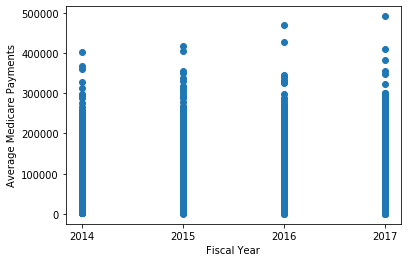

In [10]:
_ = plt.scatter(full_df['Fiscal_Year'], full_df['Average Medicare Payments'])
_ = plt.xlabel('Fiscal Year')
_ = plt.ylabel('Average Medicare Payments')
_ = plt.xticks(np.arange(2014, 2018, 1))
plt.show()

From the above, it seems like perhaps the average medicare payment is decreasing; though the highest individual payments do increase from year to year. 

Looking at the scatter plot, I noticed a potential outlier in 2017. That turned out to be a heart transplant at Stanford, which would be consistent with a higher price tag.

In [11]:
full_df.loc[full_df['Average Medicare Payments'].idxmax()]

DRG Definition               001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...
Provider Id                                                              50441
Provider Name                                             STANFORD HEALTH CARE
Provider State                                                              CA
Provider Zip Code                                                        94305
Average Covered Charges                                            3.32552e+06
Average Total Payments                                                  515707
Average Medicare Payments                                               491510
Fiscal_Year                                                               2017
DRG_Code                                                                     1
DRG_Definition               - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST ...
Name: 622085, dtype: object

I next made a bar graph looking at the mean and median payments for each fiscal year to attempt to determine if there was a trend 

Text(0, 0.5, 'Average Medicare payments')

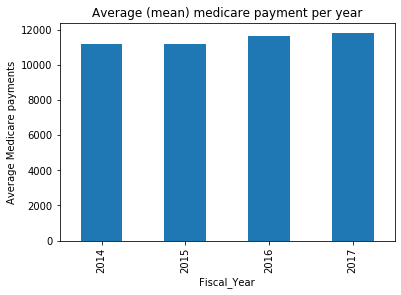

In [12]:
full_df.groupby(['Fiscal_Year'])['Average Medicare Payments'].mean().plot.bar()
plt.title("Average (mean) medicare payment per year")
plt.ylabel('Average Medicare payments')

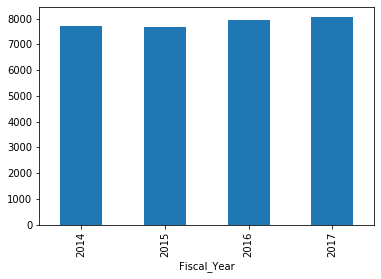

In [13]:
full_df.groupby(['Fiscal_Year'])['Average Medicare Payments'].median().plot.bar()

While the mean and median are fairly different numbers, the actual change from year to year using either method of an average appears to be fairly minimal. 

I wanted to make sure my data was normally distributed (or at least close). Turns out the overall data is right tailed. Of course, this means that my mean and median calculations will be skewed to the right. 

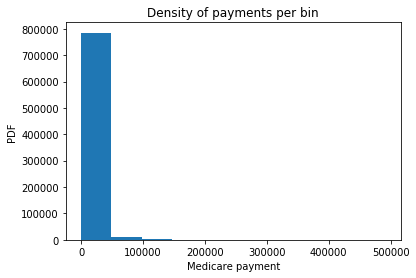

In [14]:
plt.hist(full_df['Average Medicare Payments'], bins=10)
_ = plt.xlabel("Medicare payment")
_ = plt.ylabel("PDF")
_ = plt.title("Density of payments per bin")

If I look a little closer, seeing that several of those highest numbers are very small in density, the graph is still certainly right tailed, but has a more normal distribution at the beginning. 

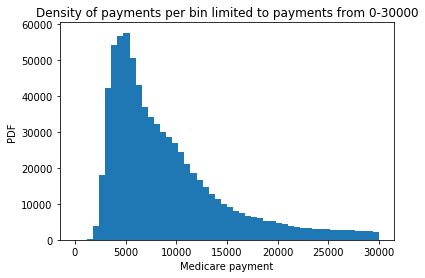

In [15]:
plt.hist(full_df['Average Medicare Payments'], bins=50, range=[0,30000])
_ =plt.xlabel("Medicare payment")
_ = plt.ylabel("PDF")
_ = plt.title("Density of payments per bin limited to payments from 0-30000")

I did some bootstrapping statistics to complete permutation hypothesis testing to see if this change is statistically significant from year to year. First, I made a function to draw the bootstrap replicates

In [16]:
def draw_bs_reps(data, func, size=1):
    bs_replicates = np.empty(size)
    
    for i in range(size):
        sample = np.random.choice(data, len(data))
        bs_replicates[i] = func(sample)
        
    return bs_replicates

I created 
- a pandas series for each individual year 
- calculated the individual means
- a series for each grouping (2014-2015, 2015-2016, 2016-2017) 
- calculated the combined means of my groups
- calculated the difference of means

In [17]:
#individual series and means
all_2014 = df1['Average Medicare Payments']
mean_2014 = np.mean(df1['Average Medicare Payments'])

all_2015 = df2['Average Medicare Payments']
mean_2015 = np.mean(df2['Average Medicare Payments'])

all_2016 = df3['Average Medicare Payments']
mean_2016 = np.mean(df3['Average Medicare Payments'])

all_2017 = df4['Average Medicare Payments']
mean_2017 = np.mean(df4['Average Medicare Payments'])

#combined groups and means
comb_1415 = pd.concat([all_2014, all_2015])
comb_mean_1415 = np.mean(comb_1415)

comb_1516 = pd.concat([all_2015, all_2016])
comb_mean_1516 = np.mean(comb_1516)

comb_1617 = pd.concat([all_2016, all_2017])
comb_mean_1617 = np.mean(comb_1617)

#differences of means
diff_means_1415 = np.mean(all_2014) - np.mean(all_2015)
diff_means_1516 = np.mean(all_2015) - np.mean(all_2016)
diff_means_1617 = np.mean(all_2016) - np.mean(all_2017)

I then shifted the arrays to make all means equal

In [18]:
#shifts for 2014-2015
shift_14 = all_2014 - mean_2014 + comb_mean_1415
shift_15_1 = all_2015 - mean_2015 + comb_mean_1415

#shifts for 2015-2016
shift_15_2 = all_2015 - mean_2015 + comb_mean_1516
shift_16_1 = all_2016 - mean_2016 + comb_mean_1516

#shifts for 2016-2017
shift_16_2 = all_2016 - mean_2016 + comb_mean_1617
shift_17 = all_2017 - mean_2017 + comb_mean_1617

Followed by calculating bootstrap replicates

In [19]:
#bootstrap reps for 2014-2015
reps_14 = draw_bs_reps(shift_14, np.mean, size=1000)
reps_15_1 = draw_bs_reps(shift_15_1, np.mean, size=1000)

#difference of means 
diff_1415 = reps_14 - reps_15_1

#calculating p value
p_1415 = np.sum((diff_1415) >= diff_means_1415) / len(diff_1415)

print('p-value for 2014-2015 =', p_1415)

p-value for 2014-2015 = 0.452


*For the above, I cannot reject the null hypothesis (that 2014 and 2015 are the same). This leads me to believe that the difference is not statistically significant and indeed, when I look at the two means, they are incredibly similar, only $5 different*

In [20]:
print("2014 mean =", np.around(mean_2014, 2), 
    "\n2015 mean =", np.around(mean_2015, 2),
    "\n2016 mean =", np.around(mean_2016, 2),
    "\n2017 mean =", np.around(mean_2017, 2))

2014 mean = 11218.47 
2015 mean = 11213.91 
2016 mean = 11656.63 
2017 mean = 11816.24


In [21]:
#bootstrap reps for 2015-2016
reps_15_2 = draw_bs_reps(shift_15_2, np.mean, size=1000)
reps_16_1 = draw_bs_reps(shift_16_1, np.mean, size=1000)

#difference of means
diff_1516 = reps_15_2 - reps_16_1

#calculating p value
p_1516 = np.sum((diff_1516) <= diff_means_1516) / len(diff_1516)

print('p-value for 2015-2016 =', p_1516)

p-value for 2015-2016 = 0.0


In [22]:
#bootstrap reps for 2016-2017
reps_16_2 = draw_bs_reps(shift_16_2, np.mean, size=1000)
reps_17 = draw_bs_reps(shift_17, np.mean, size=1000)

#difference of means
diff_1617 = reps_16_2 - reps_17

#calculating p-value
p_1617 = np.sum((diff_1617) <= diff_means_1617) / len(diff_1617)

print('p-value for 2016-2017 =', p_1617)

p-value for 2016-2017 = 0.0


For the 2015-2016 and 2016-2017 comparisons, we can reject the null hypothesis and state that there is a statistically significant difference. 

*In terms of practical significance, things become a little more grey. We see that the difference form 2015 to 2016 is just over \\$440 more on average, but only about \\$160 more from 2016 to 2017.* 

To provide a double check, I completed an ANOVA test on each grouping. These results are consistent with the bootstrapping permutation hypothese testing results that I got.  

In [23]:
print("2014-2015:", stats.f_oneway(all_2014, all_2015))
print("2015-2016:", stats.f_oneway(all_2015, all_2016))
print("2016-2017:", stats.f_oneway(all_2016, all_2017))

2014-2015: F_onewayResult(statistic=0.013882861125825117, pvalue=0.9062059400439149)
2015-2016: F_onewayResult(statistic=123.18939580690844, pvalue=1.2798326395434275e-28)
2016-2017: F_onewayResult(statistic=14.695358390270822, pvalue=0.00012637682799471428)


I then looked at the average medicare payment for each zip code using a scatter plot

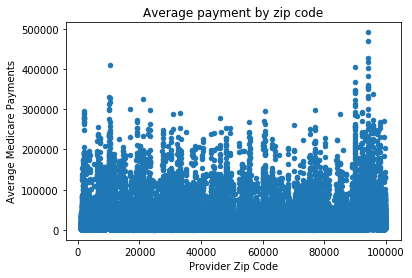

In [24]:
full_df.plot.scatter(x='Provider Zip Code', y='Average Medicare Payments')
_ = plt.title("Average payment by zip code")

The above is not particularly readable, though it does appear that most of the biggest payouts are somewhere in the 9xxxx zipcode.
Also, this is an aggregate of all the data from all four years, rather than breaking it up into each fiscal year. 

I made a 2d histogram as well, which shows me where the most payments are occuring (which appears to be the 3xxxx zip code) to see if that gave me any meaningful insights or questions to pursue. 

**I do notice that the 9xxxx zip code range appears to have one of the lower frequency of medicare payments, but we know from the above scatter plot that this zip code range has some of the highest, single payment instances of the entire country over all 4 years.**

(Of note, the 3xxxx zip code range includes TN, MS, AL, GA, and FL.
The 9xxxx zip code range includes AK, WA, OR, CA, and HI)

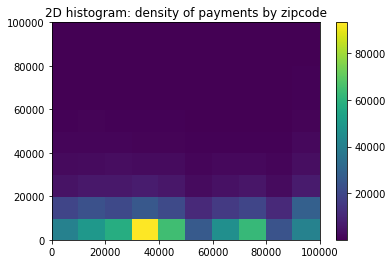

In [25]:
_ = plt.hist2d(full_df['Provider Zip Code'], full_df['Average Medicare Payments'], bins=np.arange(0, 110000, 10000))
_ = plt.colorbar()
_ = plt.title("2D histogram: density of payments by zipcode")
plt.show()

I wanted to explore other avenues with this data to determine if there were any other interesting insights.

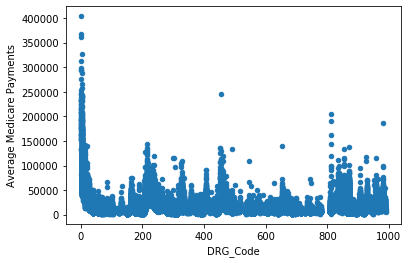

In [26]:
full_df[full_df.Fiscal_Year == 2014].plot.scatter(x='DRG_Code', y='Average Medicare Payments')

The above is difficult to gain much value from. And since there appear to be almost 1000 DRG codes, continuing to look at all of them will be difficult or impossible to fit on single plots. 

I considered picking individual DRG codes to look for any trends there. For example: DRG code 001 (Heart transplant):

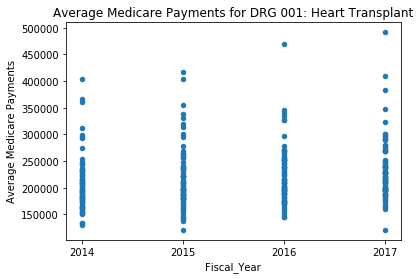

In [27]:
full_df[full_df.DRG_Code == 1].plot.scatter(x='Fiscal_Year', y='Average Medicare Payments', xticks=np.arange(2014, 2018,1), title='Average Medicare Payments for DRG 001: Heart Transplant')

However doing this for almost 1000 codes is not particulary time-efficient.

So, I decided to look at the 10 most common DRG codes (by number of times billed during 2014-2017) to see if there are any meaningful insights to be gained there. 

Running these two lines of code got me two conflicting lists.
    #full_df.DRG_Code.value_counts().head(10)
    #full_df.DRG_Definition.value_counts().head(10)

So I went by the original 'DRG Definition' column to generate my top 10 list.

Of note, CC = Complication or Comorbidity, MCC = Major Complication or Comorbidity

In [28]:
full_df['DRG Definition'].value_counts().head(10)

194 - SIMPLE PNEUMONIA & PLEURISY W CC                                      10818
470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W/O MCC    10729
291 - HEART FAILURE & SHOCK W MCC                                           10678
392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDERS W/O MCC                10641
690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC                             10626
292 - HEART FAILURE & SHOCK W CC                                            10620
190 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W MCC                           10349
603 - CELLULITIS W/O MCC                                                    10196
193 - SIMPLE PNEUMONIA & PLEURISY W MCC                                     10015
641 - MISC DISORDERS OF NUTRITION,METABOLISM,FLUIDS/ELECTROLYTES W/O MCC     9846
Name: DRG Definition, dtype: int64

First, I made a list of the top ten DRG codes and then utilized that to make a new dataframe with only the fiscal year and average medicare payments for the top ten DRG codes.

In [29]:
top_ten_codes = ['194', '470', '291', '392', '690', '292', '190', '603', '193', '641']
        
    
top_ten = pd.DataFrame(full_df, columns = ['DRG_Code', 'Average Medicare Payments', 
                                           'Fiscal_Year', 'Provider Zip Code', 'Provider State'])
top_ten = top_ten[top_ten['DRG_Code'].isin(top_ten_codes)]

I then made a bar graph to look at the payment rate for these top 10 diagnoses over the 4 year span

Text(0.5, 1, 'Medicare payments for top 10 DRG codes by year')

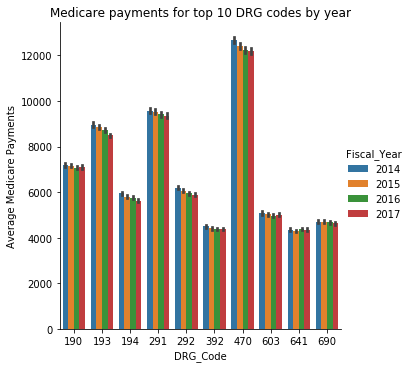

In [30]:
sns.catplot(x='DRG_Code', y='Average Medicare Payments', hue='Fiscal_Year', data=top_ten, kind='bar')
plt.title("Medicare payments for top 10 DRG codes by year")

Overall, each one seems to be decreasing, except for codes 603 and 641 which are increasing. These correspond to CELLULITIS W/O MCC and MISC DISORDERS OF NUTRITION,METABOLISM,FLUIDS/ELECTROLYTES W/O MCC respectively.

Interestingly, the codes for 193 and 470 seem to be decreasing at a greater rate. These are SIMPLE PNEUMONIA & PLEURISY W MCC and MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W/O MCC respectively, so I decided to complete a linear regression for these two codes to look at the rate of change.

In [31]:
#below calculates the mean of the average medicare payments for each year for DRG code 193
pna_2014_mean = np.mean(top_ten['Average Medicare Payments']
                   [top_ten.DRG_Code ==193][top_ten.Fiscal_Year ==2014])
pna_2015_mean = np.mean(top_ten['Average Medicare Payments']
                   [top_ten.DRG_Code ==193][top_ten.Fiscal_Year ==2015])
pna_2016_mean = np.mean(top_ten['Average Medicare Payments']
                   [top_ten.DRG_Code ==193][top_ten.Fiscal_Year ==2016])
pna_2017_mean = np.mean(top_ten['Average Medicare Payments']
                   [top_ten.DRG_Code ==193][top_ten.Fiscal_Year ==2017])

pna = pd.DataFrame(top_ten, columns = ['DRG_Code', 'Average Medicare Payments', 'Fiscal_Year']) 
pna = pna[pna.DRG_Code==193]

I made a plot to look specifically at DRG code 193

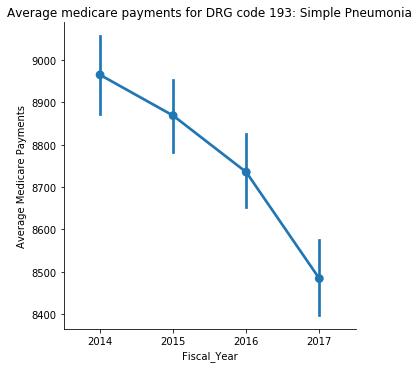

In [32]:
_ = sns.catplot(x='Fiscal_Year', y='Average Medicare Payments', 
            data=pna, kind='point')
_ = plt.title('Average medicare payments for DRG code 193: Simple Pneumonia')

#_ = sns.catplot(x='DRG_Code', y='Average Medicare Payments', hue='Fiscal_Year', data=pna, kind='bar')

I completed a similar analysis of the code 470: major joint replacement

In [33]:
joint_2014 = np.mean(top_ten['Average Medicare Payments']
                   [top_ten.DRG_Code ==470][top_ten.Fiscal_Year ==2014])
joint_2015 = np.mean(top_ten['Average Medicare Payments']
                   [top_ten.DRG_Code ==470][top_ten.Fiscal_Year ==2015])
joint_2016 = np.mean(top_ten['Average Medicare Payments']
                   [top_ten.DRG_Code ==470][top_ten.Fiscal_Year ==2016])
joint_2017 = np.mean(top_ten['Average Medicare Payments']
                   [top_ten.DRG_Code ==470][top_ten.Fiscal_Year ==2017])

I created a violin plot to see if it helped me visualize the data any better

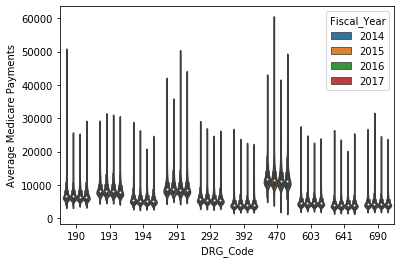

In [34]:
sns.violinplot(x='DRG_Code', y='Average Medicare Payments', hue='Fiscal_Year', data=top_ten)

I created a choropleth map to look at the top ten DRG codes and their prevalence for a given state. **It appears Indiana has a marked number of medicare payments compared to the rest of the country.** 

In [35]:
#fig = go.Figure(data=go.Choropleth(locations = top_ten['Provider State'], z=top_ten['Average Medicare Payments'], locationmode='USA-states', colorscale = 'Blues', colorbar_title = "Medicare Payments"))
#fig.update_layout(title_text = "Medicare Payments for top ten DRG codes by State", geo_scope='usa')
#fig.show()

I also wanted to look at individual codes that I thought might be interesting to me or to the general public. These were:
- 001: Heart transplant
- 535: Fractures of hip and pelvis w mcc
- 536: Fractures of hip and pelvis w/o mcc
- 619: O.R. procedures for obesity w mcc
- 629: O.R. procedures for obesity w cc
- 637: Diabetes w mcc
- 638: Diabetes w cc
- 639: Diabetes w/o cc/mcc

I utilized a similar approach as above to create a new dataframe and produce a plot looking at DRG per year 

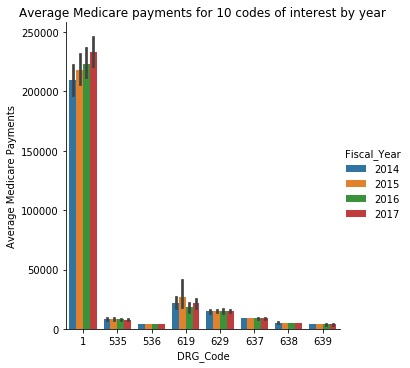

In [36]:
interest_codes = ['1', '535', '536', '619', '629', '637', '638', '639']
interest = pd.DataFrame(full_df, columns = ['DRG_Code', 'Average Medicare Payments', 'Fiscal_Year', 'Provider Zip Code', 'Provider State'])
interest = interest[interest['DRG_Code'].isin(interest_codes)]

sns.catplot(x='DRG_Code', y='Average Medicare Payments', hue='Fiscal_Year', data=interest, kind='bar')
_ = plt.title("Average Medicare payments for 10 codes of interest by year")

From the above, I notice that the payments for heart transplants went up each year. It's a little difficult to see the possible change on the other 7 codes, so I made the same graph as above without the first code. 

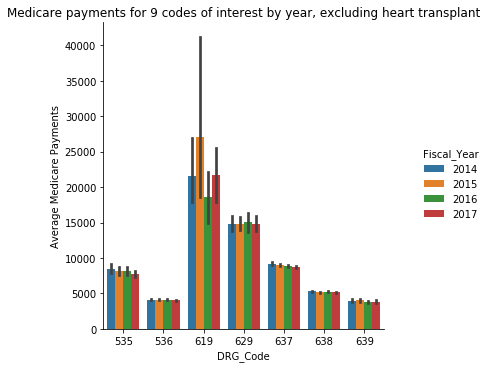

In [37]:
interest_codes_less = ['535', '536', '619', '629', '637', '638', '639']
interest_less = pd.DataFrame(full_df, columns = ['DRG_Code', 'Average Medicare Payments', 'Fiscal_Year', 'Provider Zip Code'])
interest_less = interest_less[interest_less['DRG_Code'].isin(interest_codes_less)]

sns.catplot(x='DRG_Code', y='Average Medicare Payments', hue='Fiscal_Year', data=interest_less, kind='bar')
_ = plt.title("Medicare payments for 9 codes of interest by year, excluding heart transplant")

The above gives me a better look at each code; they still don't seem to have much difference from year to year. 

I do note that the code 619 (O.R. procedures for obesity w mcc) has more variability from year to year than I've seen in other DRG codes. 

I created a choropleth map to look at these codes as well, however there doesn't appear to be much meaningful data here. I included the code for reference but commented it out for space saving. 

In [38]:
#fig = go.Figure(data=go.Choropleth(locations = interest['Provider State'], z=interest['Average Medicare Payments'], locationmode='USA-states', colorscale = 'Greens', colorbar_title = "Medicare Payments"))
#fig.update_layout(title_text = "Medicare Payments for top ten DRG codes by State", geo_scope='usa')
#fig.show()

### At the end of data wrangling and storytelling, my observations are as follows:
- The highest individual payments appear to be increasing but the average is very similar from year to year.
- Some of the biggest individual payments are in the 9xxxx zip code, which has one of the lower frequencies of payments
- the 3xxxx zip code has the highest frequency of payments
- Of the top ten most common codes, 6 are fairly similar from year to year, 2 appear to be decreasing at a greater rate, and 2 are increasing
- Additionally, of the ten most common codes, Indiana appears to have a marked amount more of medicare payments compared to the rest of the country
- Of the 8 codes I selected out of interest, one is clearly rising each year, 1 is variable and the rest are again fairly similar or decreasing slightly

### Questions I will consider moving foward:
- Is the average Medicare payment statistically significantly changing from year to year?
    - 2014-2015, no 
    - 2015-2016 yes, likely the only practically significant one
    - 2016-1017 yes 
- Can you predict what the medicare payment for any given DRG code might be in the next 1-2 years? (specifically ones that seem to have a clearer trend such as major joint replacement or heart transplant)
- Is there a correlation between DRG codes billed and state?